#### Vilnius Coding School
## Kartotinės tiesinės regresijos modelis
#### Atliko: Jūratė Navickė
#### Vilnius, 2020

Darbo tikslas yra identifikuoti nepriklausomus kintamuosius, kurie įtakoja deimantų kainą ir sukonstruoti du kartotinės tiesinės regresijos (*multiple linear regression*) modelio variantus, t.y., 
prognozuoti vieno deimantų karato kainą (*price_per_carat*) ir deimanto kainą (*price_per_diamond*).
Darbui pasirinkau duomenų rinkinį (*dataset*) https://www.kaggle.com/shivam2503/diamonds.

In [1]:
import pandas as pd
import numpy as np
import numbers

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [4]:
import statsmodels.formula.api as smf

In [5]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics

## Duomenų apžvalga, vizualizacija, tvarkymas

Pradiniame duomenų rinkinyje yra 53940 eilutės (index) ir 10 stulpelių (column):
* **price** deimanto kaina US doleriais (*326-18823*)
* **carat** deimanto svoris karatais (*0.2-5.01*)
* **cut** šlifavimo kokybė (*Fair, Good, Very Good, Premium, Ideal*)
* **color** deimanto spalva (*nuo J (geltonai tonuotas) iki D (tobula, visiškai bespalvis)*)
* **clarity** deimanto skaidrumas (*I1 (ne visai skaidrus), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (idealiai skaidrus)*)
* **x** ilgis mm (*0-10.74*)
* **y** plotis mm (*0-58.9*)
* **z** gylis mm (*0-31.8*)
* **depth** procentinis gylis $= \frac{z}{\operatorname{mean}(x, y)} = \frac{2 \cdot z}{(x + y)}$ (*43-79*)
* **table** deimanto viršaus plotis procentais nuo jo vidutinio skersmens (*43-95*)


In [6]:
df = pd.read_csv("diamonds.csv")

In [7]:
df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [8]:
len(df)

53940

In [9]:
df.isnull().sum()

Unnamed: 0    0
carat         0
cut           0
color         0
clarity       0
depth         0
table         0
price         0
x             0
y             0
z             0
dtype: int64

In [10]:
df.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [11]:
df['price_per_carat'] = df['price']/df['carat']

In [12]:
df.rename(columns={'price' : 'price_per_diamond'}, inplace = True)

Vizualizuoju kintamųjų *price_per_diamond* ir *price_per_diamond* priklausomybę nuo kategorinių kintamųjų.

In [13]:
cuts = df.groupby('cut').mean().reindex(['Fair', 'Good', 'Very Good', 'Premium', 
                                         'Ideal'])[['price_per_diamond', 'price_per_carat']]
cuts

,price_per_diamond,price_per_carat
cut,,
Fair,4358.757764,3767.255681
Good,3928.864452,3860.027680
Very Good,3981.759891,4014.128366
Premium,4584.257704,4222.905374
Ideal,3457.541970,3919.699825


(2500, 5500)

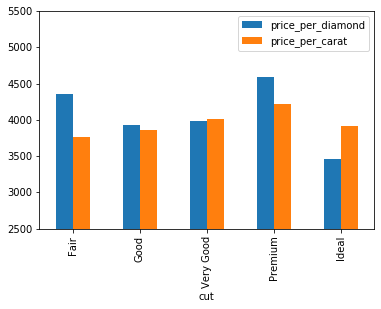

In [14]:
cuts.plot(kind = 'bar')
plt.ylim(2500, 5500)

In [15]:
colors = df.groupby('color').mean().reindex(['J', 'I', 'H', 'G', 'F', 'E', 'D'])[['price_per_diamond', 
                                                                                  'price_per_carat']]
colors

,price_per_diamond,price_per_carat
color,,
J,5323.818020,3825.649192
I,5091.874954,3996.402051
H,4486.669196,4008.026941
G,3999.135671,4163.411524
F,3724.886397,4134.730684
E,3076.752475,3804.611475
D,3169.954096,3952.564280


(2500, 5500)

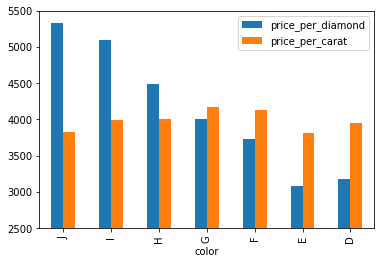

In [16]:
colors.plot(kind = 'bar')
plt.ylim(2500, 5500)

In [17]:
clarities = df.groupby('clarity').mean().reindex(['I1', 'SI2', 'SI1', 'VS2', 'VS1', 
                                                  'VVS2', 'VVS1', 'IF'])[['price_per_diamond', 'price_per_carat']]
clarities

,price_per_diamond,price_per_carat
clarity,,
I1,3924.168691,2796.296437
SI2,5063.028606,4010.853865
SI1,3996.001148,3849.078018
VS2,3924.989395,4080.526787
VS1,3839.455391,4155.816808
VVS2,3283.737071,4204.166013
VVS1,2523.114637,3851.410558
IF,2864.839106,4259.931736


(2000, 5500)

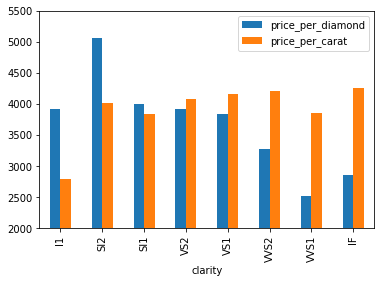

In [18]:
clarities.plot(kind = 'bar')
plt.ylim(2000, 5500)

Manau, kad kategoriniai kintamieji *cut*, *color* ir *clarity* turi įtaką kainai. Ketinu šiuos kategorinius kintamuosius naudoti regresijos modelyje, todėl jų informaciją perkelsiu į stulpelius, dalindama kiekvieną į dvi prasmines grupes (jei išskirsime kiekvieną kategorinio kintamojo reikšmę, modelis turės per daug sąlygų ir tai gali sąlygoti multikolinearumą): 
* reikšmę **1** priskirsiu kintamojo reikšmių rinkiniui, kuris deimantą daro aukštesnės kokybės ir brangesniu.
* kitu atveju priskiriu reikšmę **0**.

In [19]:
df['cut_level'] = df['cut'].apply(lambda x: 1 if (x == 'Ideal') | (x == 'Premium') else 0)

In [20]:
df['color_scale'] = df['color'].apply(lambda y: 1 if y in ['D', 'E', 'F'] else 0)

In [21]:
df['clarity_grade'] = df['clarity'].apply(lambda z: 1 if z in ['IF', 'VVS1', 'VVS2'] else 0)

In [22]:
df.head()

,carat,cut,color,clarity,depth,table,price_per_diamond,x,y,z,price_per_carat,cut_level,color_scale,clarity_grade
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43,1417.391304,1,1,0
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31,1552.380952,1,1,0
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31,1421.739130,0,1,0
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63,1151.724138,1,0,0
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75,1080.645161,0,0,0


In [23]:
df.columns

Index(['carat', 'cut', 'color', 'clarity', 'depth', 'table',
       'price_per_diamond', 'x', 'y', 'z', 'price_per_carat', 'cut_level',
       'color_scale', 'clarity_grade'],
      dtype='object')

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   carat              53940 non-null  float64
 1   cut                53940 non-null  object 
 2   color              53940 non-null  object 
 3   clarity            53940 non-null  object 
 4   depth              53940 non-null  float64
 5   table              53940 non-null  float64
 6   price_per_diamond  53940 non-null  int64  
 7   x                  53940 non-null  float64
 8   y                  53940 non-null  float64
 9   z                  53940 non-null  float64
 10  price_per_carat    53940 non-null  float64
 11  cut_level          53940 non-null  int64  
 12  color_scale        53940 non-null  int64  
 13  clarity_grade      53940 non-null  int64  
dtypes: float64(7), int64(4), object(3)
memory usage: 5.8+ MB


In [25]:
df.describe()

,carat,depth,table,price_per_diamond,x,y,z,price_per_carat,cut_level,color_scale,clarity_grade
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734,4008.394796,0.655209,0.484131,0.194865
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699,2012.665747,0.475304,0.499753,0.396100
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000,1051.162791,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000,2477.944444,0.000000,0.000000,0.000000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000,3495.198031,1.000000,0.000000,0.000000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000,4949.599702,1.000000,1.000000,0.000000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000,17828.846154,1.000000,1.000000,1.000000


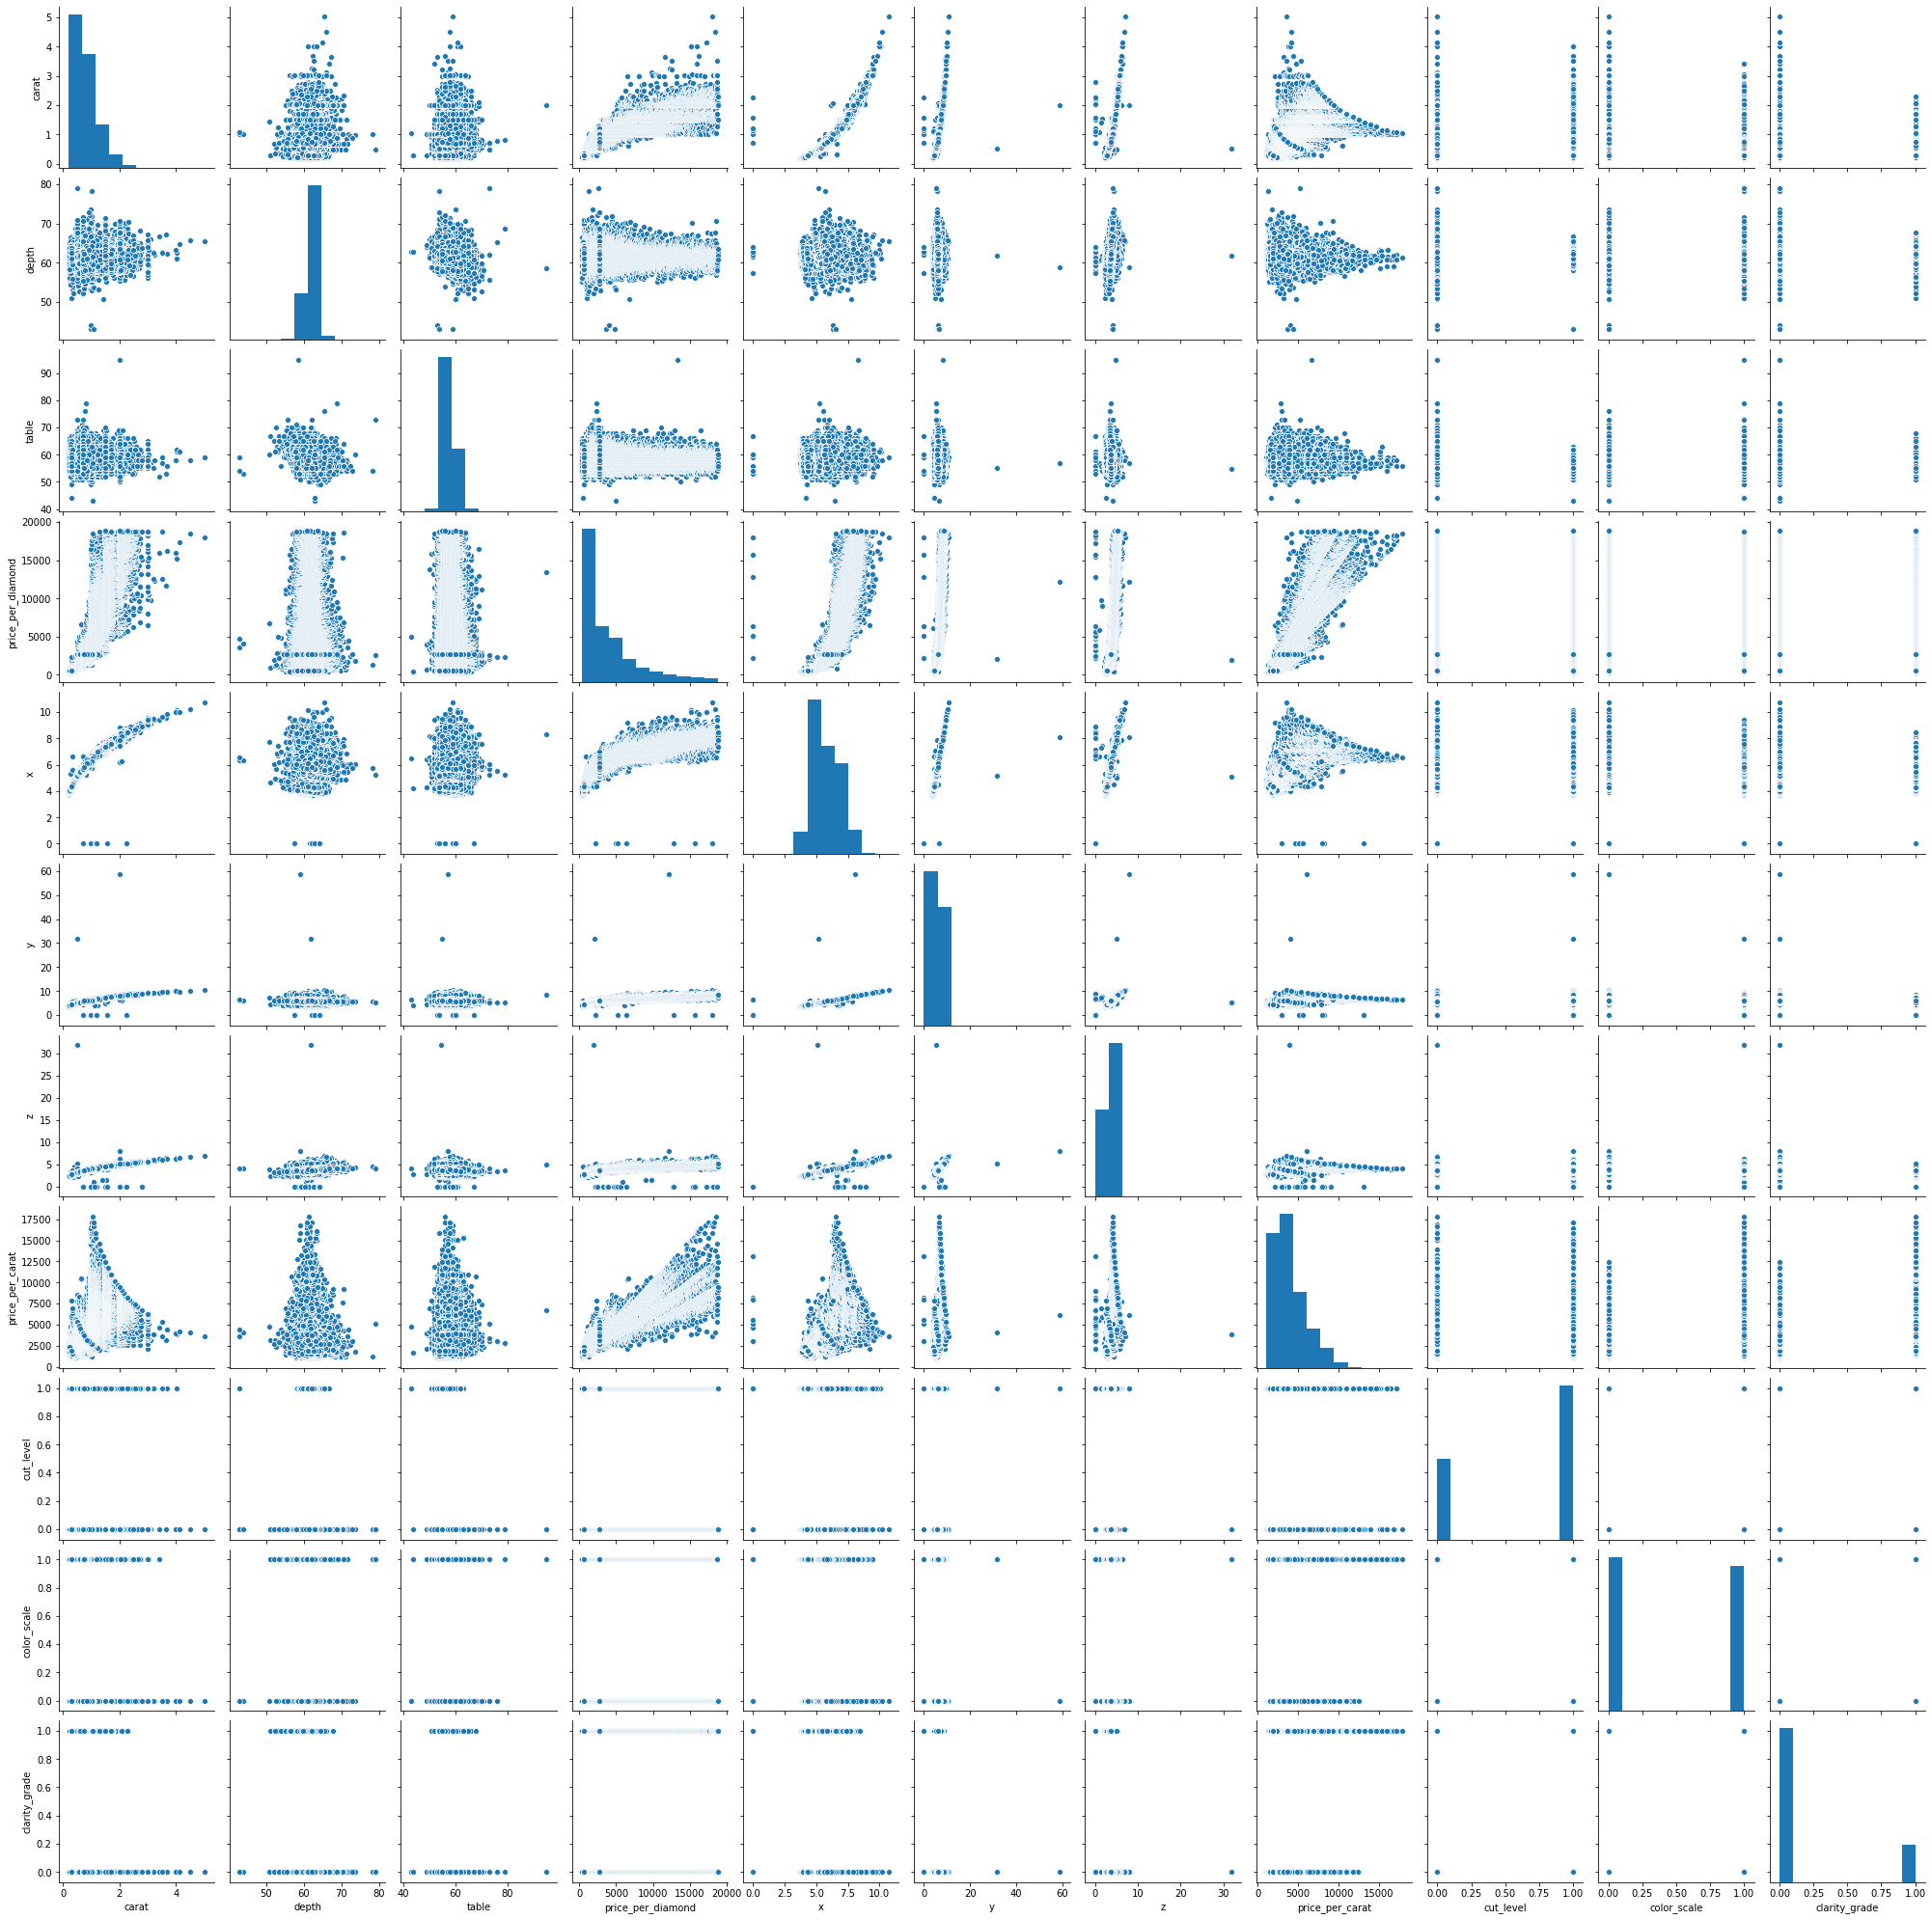

In [26]:
sns.pairplot(df)

### Nepriklausomų kintamųjų multikolinearumo tikrinimas

In [27]:
df.corr()

,carat,depth,table,price_per_diamond,x,y,z,price_per_carat,cut_level,color_scale,clarity_grade
carat,1.000000,0.028224,0.181618,0.921591,0.975094,0.951722,0.953387,0.769744,-0.061963,-0.227561,-0.258999
depth,0.028224,1.000000,-0.295779,-0.010647,-0.025289,-0.029341,0.094924,-0.035669,-0.205481,-0.044693,-0.043034
table,0.181618,-0.295779,1.000000,0.127134,0.195344,0.183760,0.150929,0.084700,-0.256081,-0.004129,-0.125329
price_per_diamond,0.921591,-0.010647,0.127134,1.000000,0.884435,0.865421,0.861249,0.912377,-0.012300,-0.144494,-0.121454
x,0.975094,-0.025289,0.195344,0.884435,1.000000,0.974701,0.970772,0.787692,-0.051240,-0.210584,-0.282890
y,0.951722,-0.029341,0.183760,0.865421,0.974701,1.000000,0.952006,0.772065,-0.058759,-0.205024,-0.272683
z,0.953387,0.094924,0.150929,0.861249,0.970772,0.952006,1.000000,0.765884,-0.080909,-0.209031,-0.278979
price_per_carat,0.769744,-0.035669,0.084700,0.912377,0.787692,0.772065,0.765884,1.000000,0.020288,-0.021551,0.020191
cut_level,-0.061963,-0.205481,-0.256081,-0.012300,-0.051240,-0.058759,-0.080909,0.020288,1.000000,-0.021553,0.068350
color_scale,-0.227561,-0.044693,-0.004129,-0.144494,-0.210584,-0.205024,-0.209031,-0.021551,-0.021553,1.000000,-0.029192


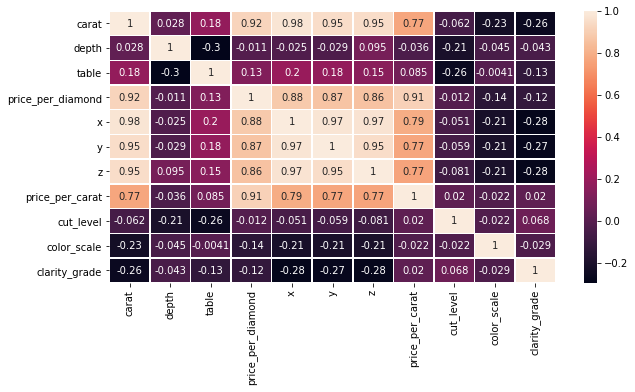

In [28]:
fig, ax = plt.subplots(figsize=(10,5))  
sns.heatmap(df.corr(), linewidths=.5, annot = True, ax = ax)

Kintamieji *x*, *y*, *z* stipriai koreliuoja su *carat* kintamuoju, taip pat jie naudojami *table* ir *deph* skaičiavime. Todėl kintamųjų *x*, *y*, *z*, *table*, *deph* nenaudosiu regresinio modelio konstravime.

## Prognozavimas 
### *price_per_carat*

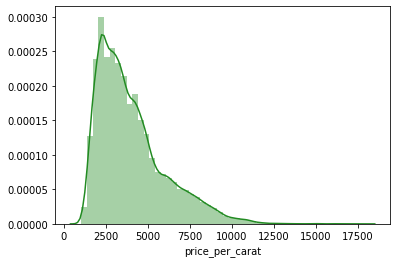

In [29]:
sns.distplot(df['price_per_carat'], color = "forestgreen")

In [30]:
feature_cols = ['carat', 'cut_level', 'color_scale', 'clarity_grade']
X = df[feature_cols]       # stebimi kintamieji
y = df['price_per_carat']  # priklausomas kintamasis

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)

In [32]:
for var in [X_train, X_test, y_train, y_test]:
    print(var.shape)

(43152, 4)
(10788, 4)
(43152,)
(10788,)


In [33]:
linear_carat = LinearRegression()
linear_carat.fit(X_train, y_train)
r_sq_carat = linear_carat.score(X_test, y_test)
print('R-squared:', r_sq_carat)

R-squared: 0.6780906933031233


In [34]:
print('Modelio laisvasis narys (intercept):', linear_carat.intercept_)

Modelio laisvasis narys (intercept): 224.85414683565295


In [35]:
coeff_df_carat = pd.DataFrame(linear_carat.coef_, X.columns, columns = ['Coefficients'])
coeff_df_carat

,Coefficients
carat,3756.371284
cut_level,263.790307
color_scale,761.309054
clarity_grade,1279.344645


In [36]:
predictions_carat = linear_carat.predict(X_test)
predictions_carat

array([2669.51820739, 4444.20319079, 4031.84666687, ..., 2668.67389007,
       5870.29018744, 4281.73513359])

In [37]:
pred_carat_df = pd.DataFrame(linear_carat.predict(X_test), columns = ['predictions'])
pred_carat_df.describe()

,predictions
count,10788.000000
mean,4005.354759
std,1676.863131
min,1088.819542
25%,2790.065735
50%,3731.336964
75%,4846.035144
max,15551.693303


Text(0, 0.5, 'predictions_carat')

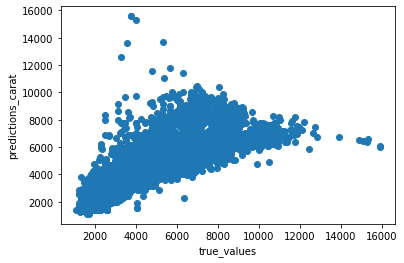

In [38]:
plt.scatter(y_test, predictions_carat)
plt.xlabel('true_values')
plt.ylabel('predictions_carat')

#### Modelio paklaida

Text(0.5, 0, 'price_per_carat paklaida')

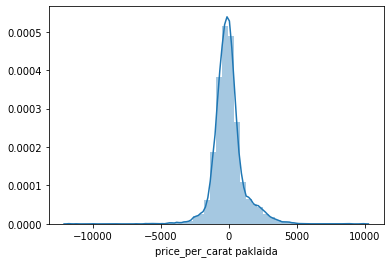

In [39]:
sns.distplot(y_test - predictions_carat)
plt.xlabel("price_per_carat paklaida")

#### Kintamųjų priklausomybės analizė

In [40]:
est_carat = smf.ols('price_per_carat ~ carat + cut_level + color_scale + clarity_grade', df).fit()

In [41]:
est_carat.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        price_per_carat   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                 2.869e+04
Date:                Mon, 27 Apr 2020   Prob (F-statistic):               0.00
Time:                        18:37:46   Log-Likelihood:            -4.5611e+05
No. Observations:               53940   AIC:                         9.122e+05
Df Residuals:                   53935   BIC:                         9.123e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       239.4983     14.832     16.147      0.000     210.427     268.569
carat          3740.2971     11.050    338.492      0.000    3718.639    3761.955
cut_level       261.9139     10.350     25.307      0.000     241.629     282.199
color_scale     755.2246     10.119     74.637      0.000     735.392     775.057
clarity_grade  1268.2081     12.881     98.455      0.000    1242.961    1293.455
==============================================================================
Omnibus:                    11230.455   Durbin-Watson:                   1.513
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           179978.784
Skew:                           0.563   Prob(JB):                         0.00
Kurtosis:                      11.877   Cond. No.                         6.15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Išvados 
* Visi modelio kintamieji reikšmingi.
* Atsitiktinės modelio paklaidos vidurkis artimas nuliui.

### *price_per_diamond*

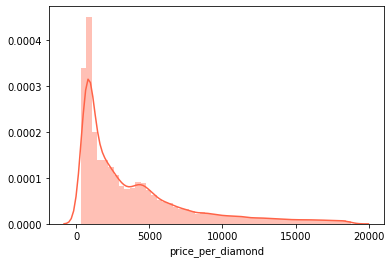

In [42]:
sns.distplot(df['price_per_diamond'], color = "tomato")

In [43]:
feature_cols = ['carat', 'cut_level', 'color_scale', 'clarity_grade']

In [44]:
X = df[feature_cols]        
y = df['price_per_diamond']

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)#

In [46]:
for var in [X_train, X_test, y_train, y_test]:
    print(var.shape)

(43152, 4)
(10788, 4)
(43152,)
(10788,)


In [47]:
linear_diamond = LinearRegression()
linear_diamond.fit(X_train, y_train)
r_sq_diamond = linear_diamond.score(X_test, y_test)
print('R-squared:', r_sq_diamond)

R-squared: 0.8704513402019839


In [48]:
print('Modelio laisvasis narys (intercept):', linear_diamond.intercept_)

Modelio laisvasis narys (intercept): -3442.9920523362853


In [49]:
coeff_df_diamond = pd.DataFrame(linear_diamond.coef_, X.columns, columns = ['Coefficients'])
coeff_df_diamond

,Coefficients
carat,8238.323940
cut_level,343.261863
color_scale,665.099218
clarity_grade,1327.780627


In [50]:
predictions_diamond = linear_diamond.predict(X_test)
predictions_diamond

array([ 205.24818282, 3328.11567797, 2188.47923129, ...,  438.66899606,
       7698.50747481, 5454.39780317])

In [51]:
pred_diamond_df = pd.DataFrame(linear_diamond.predict(X_test), columns = ['predictions'])
pred_diamond_df.describe()

,predictions
count,10788.000000
mean,3923.711469
std,3754.641589
min,-1548.177546
25%,943.081844
50%,3012.311625
75%,5886.076208
max,29935.948811


Text(0, 0.5, 'predictions_diamond')

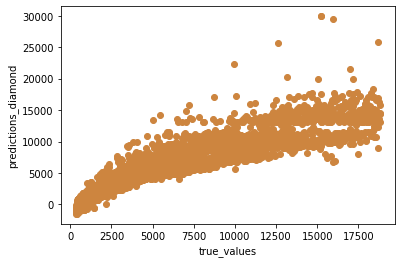

In [52]:
plt.scatter(y_test, predictions_diamond, color = "peru")
plt.xlabel('true_values')
plt.ylabel('predictions_diamond')

#### Modelio paklaida

Text(0.5, 0, 'price_per_diamond paklaida')

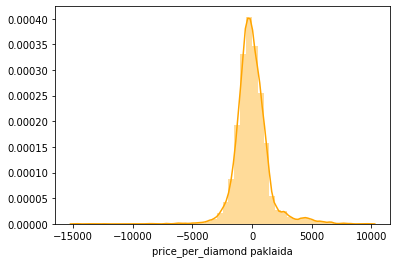

In [53]:
sns.distplot(y_test - predictions_diamond, color = "orange")
plt.xlabel("price_per_diamond paklaida")

#### Kintamųjų priklausomybės analizė

In [54]:
est_diamond = smf.ols('price_per_diamond ~ carat + cut_level + color_scale + clarity_grade ', df).fit()

In [55]:
est_diamond.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      price_per_diamond   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                 9.180e+04
Date:                Mon, 27 Apr 2020   Prob (F-statistic):               0.00
Time:                        18:37:48   Log-Likelihood:            -4.6835e+05
No. Observations:               53940   AIC:                         9.367e+05
Df Residuals:                   53935   BIC:                         9.367e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -3429.7470     18.608   -184.312      0.000   -3466.220   -3393.275
carat          8221.7825     13.863    593.067      0.000    8194.611    8248.954
cut_level       344.5007     12.985     26.532      0.000     319.051     369.950
color_scale     658.7447     12.695     51.891      0.000     633.863     683.627
clarity_grade  1321.0249     16.161     81.744      0.000    1289.350    1352.700
==============================================================================
Omnibus:                    10863.610   Durbin-Watson:                   0.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           174213.995
Skew:                           0.526   Prob(JB):                         0.00
Kurtosis:                      11.741   Cond. No.                         6.15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Išvados 
* Visi modelio kintamieji reikšmingi.
* Atsitiktinės modelio paklaidos vidurkis pakankamai artimas nuliui.